<a href="https://colab.research.google.com/github/AryanXTH/AI-and-ML/blob/main/AI_CourseWork2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification with Recurrent Neural Network and It’s Variant.

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## Required Libraries

In [ ]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import contractions
from wordcloud import WordCloud
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder

# About the Dataset

The dataset contains two columns headline and category where there are 5 different types of news category - Sports, Tech, Money, Culture & Arts, and Education.

An model is to be built which can classify the type of news according to the headline provided.

In [ ]:
df = pd.read_csv("dataset/news_category.csv") # loading the dataset into a dataframe

## Exploratory Data Analysis

### Printing random samples from dataframe

In [ ]:
df.sample(10)

,headline,category
10518,Robert Doisneau Google Doodle Pays Homage To F...,TECH
9146,'Rube Goldberg Freerunning': Jason Paul's Incr...,CULTURE & ARTS
1915,Five Soccer Cities Making America Great Again!,SPORTS
10838,Natural Disaster Relief: IRS Offers Victims Ta...,MONEY
179,'Ma Rainey's Black Bottom' Is Viola Davis At H...,CULTURE & ARTS
6163,"Become a Millionaire, Start Skateboarding",SPORTS
1122,Jon Stewart Co-Hosts SportsCenter To Support W...,SPORTS
7940,Betty Draper Photo By Frank Ockenfels Will Ful...,CULTURE & ARTS
2091,These Hilarious Quips About The Olympics Nail ...,SPORTS
1043,Moving Forward From Charlottesville,EDUCATION


In [ ]:
# Print all column names
for column in df.columns.tolist():
    print(column)

headline
category


In [ ]:
df.size

22050

In [ ]:
df.isnull().sum()

headline    0
category    0
dtype: int64

In [ ]:
# Check for duplicates
duplicate_rows = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

Number of duplicate rows: 78


## Initial Vizualization of data

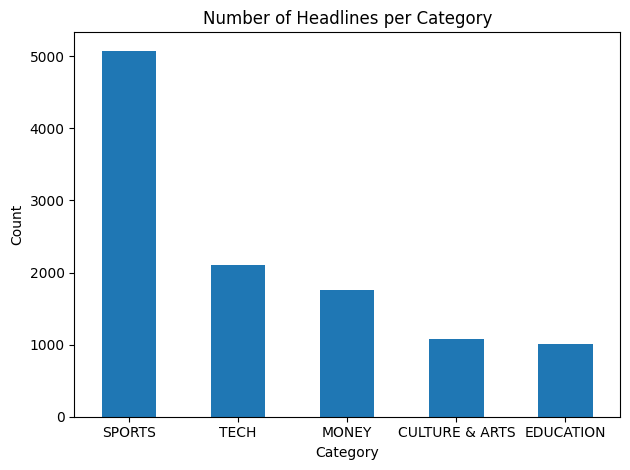

In [ ]:
category_counts = df['category'].value_counts()

category_counts.plot(kind="bar")
plt.title('Number of Headlines per Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

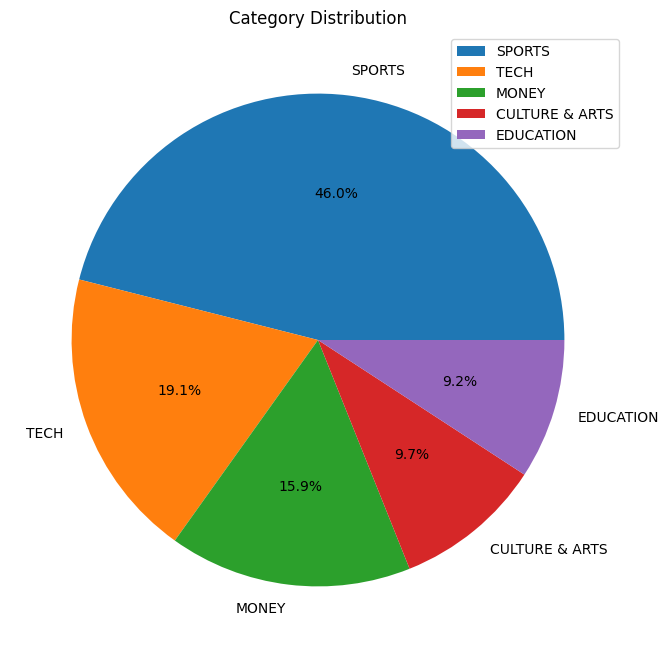

In [ ]:
df['category'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(15,8))
plt.title('Category Distribution')
plt.ylabel('')
plt.legend()
plt.show()

## Data preprocessing

### Convert all texts to lowercase

In [ ]:
def lower_case(text):
  """
  This function converts all the text in input text to lower order.
  Input Args:
  text : input text.
  Returns:
  lower_text : text converted to small/lower order.
  """
  lower_text = text.lower()
  return lower_text

### Remove the URLs

In [ ]:
def remove_urls(text):
  """
  This function will try to remove URL present in out dataset and replace it with space using regex library.
  Input Args:
  text: string of text that may contain URLs.
  Output Args:
  text: URLs replaces with text
  """
  url_pattern = re.compile(r'https?://\S+|www\.\S+')
  return url_pattern.sub(r'', text)


### Remove Unwanted Emojis or blockers from text

In [ ]:
def remove_emoji(text):
  """
  This function will replace the emoji in string with whitespace.
  Input Args:
  text: string of text that may contain URLs.
  Output Args:
  emoji_removed_text: URLs replaces with text.
  """
  emoji_removed_text = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
  return emoji_removed_text.sub(r' ', text)

### Remove unwanted characters

In [ ]:
def removeunwanted_characters(document):
  """
  This function will remove all the unwanted characters from the input dataset.
  Input Args:
  document: A text data to be cleaned.
  Return:
  document: A cleaned document.
  """
  # remove user mentions
  document = re.sub("@[A-Za-z0-9_]+"," ", document)
  # remove hashtags
  document = re.sub("#[A-Za-z0-9_]+","", document)
  # remove punctuation
  document = re.sub("[^0-9A-Za-z ]", "" , document)
  #remove emojis
  document = remove_emoji(document)
  # remove double spaces
  document = document.replace('  ',"")
  return document.strip()

### Remove Punctuations

In [ ]:
def remove_punct(text):
  """
  This function removes the punctutations present in our text data.
  Input Args:
  text: text data.
  Returns:
  text: cleaned text.
  """
  tokenizer = RegexpTokenizer(r"\w+")
  lst=tokenizer.tokenize(' '.join(text))
  return lst

### Remove Stopwords

In [ ]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text_tokens):
  """
  This function removes all the stopwords present in out text tokens.
  Input Args:
  text_tokens: tokenize input of our datasets.
  Returns:
  result_tokens: list of token without stopword.
  """

  result_tokens = []
  for token in text_tokens:
    if token not in stop_words:
       result_tokens.append(token)
  return result_tokens

### Handle Contractions

Convert words like don't --> do not

In [ ]:
def handle_contractions(text):
    """
    This function removes all the contractions
    Input Args:
    text: text as input
    Returns:
    result_tokens: contractions handled texts
    """
    return contractions.fix(text)

### Lemmatization

In [ ]:
def lemmatization(token_text):
  """
  This function performs the lemmatization operations as explained above.
  Input Args:
  token_text: list of tokens.
  Returns:
  lemmatized_tokens: list of lemmatized tokens.
  """
  wordnet = WordNetLemmatizer()
  lemmatized_tokens = [wordnet.lemmatize(token, pos = 'v') for token in token_text]

  return lemmatized_tokens

In [ ]:
def text_cleaning_pipeline(dataset):
   """
   This function compiles all the text cleaning functions using lemmatization, and prepare it for
   model training.

   Input Args:
   dataset: all dataset

   Returns:
   tokens: tokenized and cleaned dataset
   """
   # Convert the input to small/lower order.
   data = lower_case(dataset)
   # Remove URLs
   data = remove_urls(data)
   # Remove emojis
   data = remove_emoji(data)
   # Remove all other unwanted characters.
   data = removeunwanted_characters(data)
   # Create tokens.
   tokens = data.split()
   # Remove stopwords:
   tokens = remove_punct(tokens)
   tokens = remove_stopwords(tokens)
   tokens = lemmatization(tokens)

   return " ".join(tokens)

In [ ]:
df["cleaned_headline"]  = df["headline"].apply(text_cleaning_pipeline)
df["cleaned_category"]  = df["category"].apply(text_cleaning_pipeline)

# Drop old columns from the DataFrame
df.drop(["headline", "category"], axis=1, inplace=True)

In [ ]:
df.sample(10)

,cleaned_headline,cleaned_category
7922,paco pomets surreal paintings take vintage pho...,culturearts
7169,artists create mesmerize miniature worlds with...,culturearts
2713,look like space jam 2 actually go happen,sport
10947,nina chanel abneys paintings mix pretty politi...,culturearts
2517,thiel show tech billionaires new robber barons,tech
1534,top 10 tech trend transform humanity,tech
2423,golfers twoball trick shoot make us say howd,sport
3866,encryption debate get fiercer silicon valley d...,tech
2781,espnw cant comment section internet awful,sport
6777,steal paintings find 40 years later,culturearts


## Visualize Cleaned Data

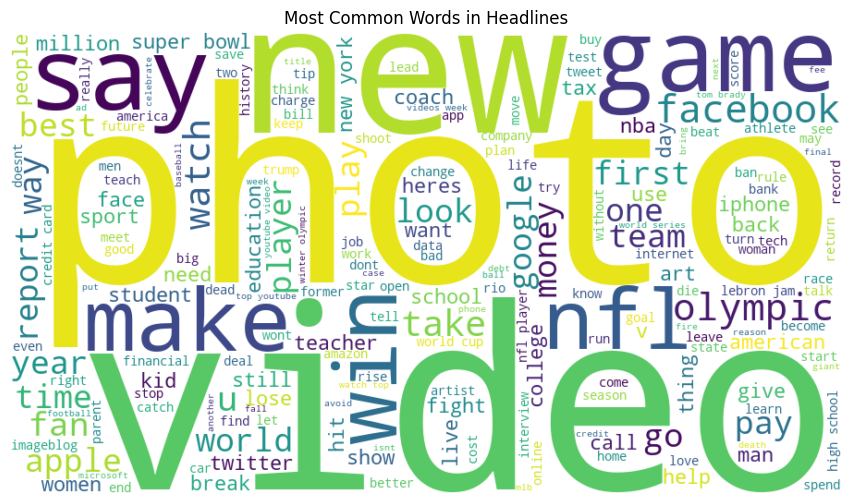

In [ ]:
text = ' '.join(df['cleaned_headline'])

# Generate WordCloud
wordcloud = WordCloud(width=900, height=500, background_color='white').generate(text)

# Plot
plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Headlines")
plt.show()

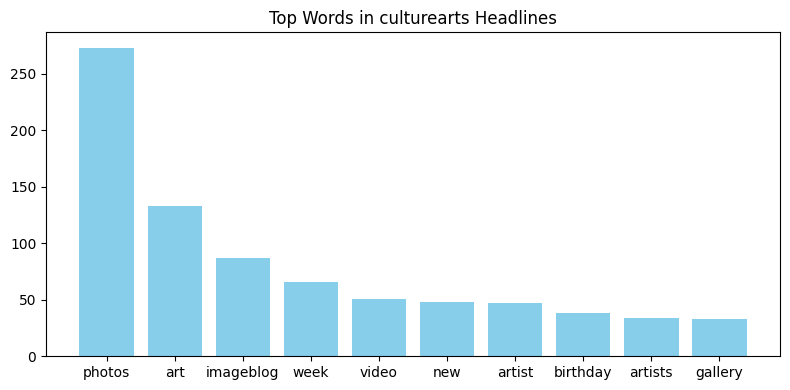

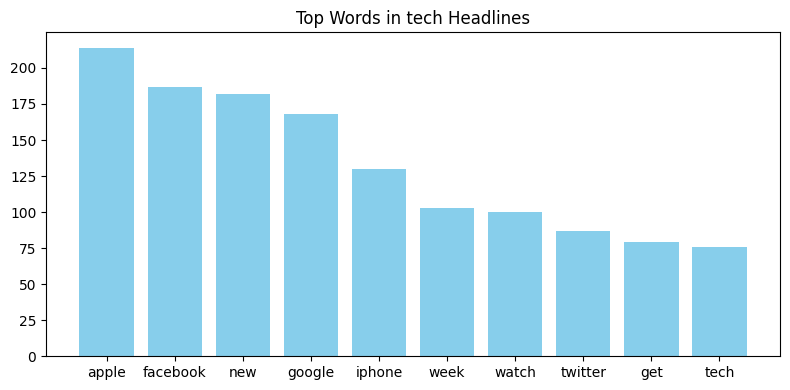

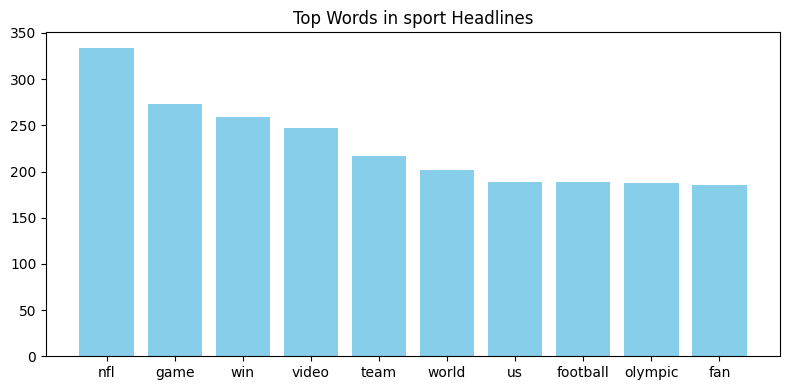

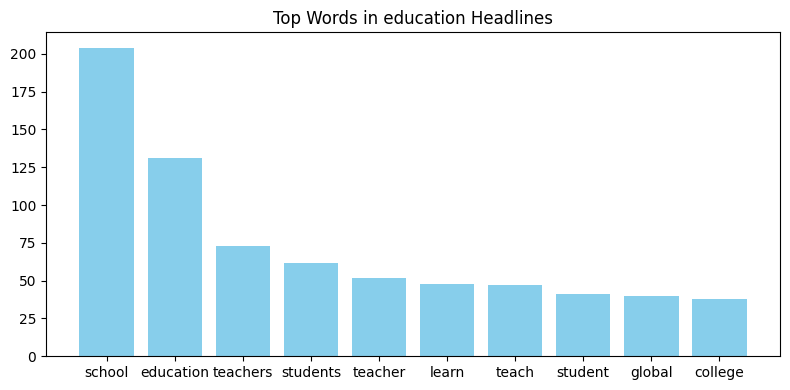

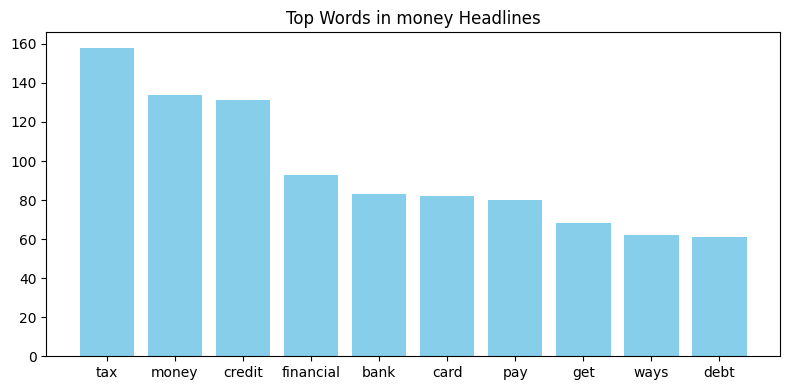

In [ ]:
from collections import Counter

categories = df['cleaned_category'].unique()

for category in categories:
    tokens = [
        word
        for token_list in df[df['cleaned_category'] == category]['cleaned_headline']
        for word in (token_list if isinstance(token_list, list) else token_list.split())
    ]

    word_freq = Counter(tokens).most_common(10)

    words, counts = zip(*word_freq)
    plt.figure(figsize=(8, 4))
    plt.bar(words, counts, color='skyblue')
    plt.xticks(rotation=0)
    plt.title(f"Top Words in {category} Headlines")
    plt.tight_layout()
    plt.show()

## Tokenization and Padding

### Splitting dataset into 80% training and 20% testing

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_headline'], df['cleaned_category'], test_size=0.2, random_state=42)

### Tokenizing text into sequences of integers

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train) # Fit tokenizer on training data

texts = df['cleaned_headline']

# Pad sequences
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, padding='post')

# Convert text to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

vocab_size = len(tokenizer.word_index) + 1
word_index = tokenizer.word_index


In [ ]:
# Assigned Labels
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Mapping:")
for label, idx in label_mapping.items():
    print(f"{label} → {idx}")

Label Mapping:
culturearts → 0
education → 1
money → 2
sport → 3
tech → 4


In [ ]:
# import pickle

# with open('tokenizer.pkl', 'wb') as f:
#     pickle.dump(tokenizer, f)

# with open('label_encoder.pkl', 'wb') as f:
#    pickle.dump(le, f)

In [ ]:
print(X_train_seq[0])

[148, 662, 273, 2117, 148, 503]


### Applying padding to all sequences for them to have the same length

In [ ]:
# Calculate the percentile length (e.g., 80th percentile)
max_len = int(np.percentile([len(seq) for seq in X_train_seq], 80))

# Pad sequences to make sure they're all the same length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

X_train_pad = np.array(X_train_pad)
X_test_pad = np.array(X_test_pad)

In [ ]:
print("Example padded sequence:", X_train_pad[0])

Example padded sequence: [ 148  662  273 2117  148  503    0    0    0]


# Model Building and Training

## Simple RNN model

should use - rnn model.add(Embedding(input dim= , output dim= , input length= ))

In [ ]:
def build_rnn_model():
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
        SimpleRNN(64),
        Dense(6, activation='softmax')
    ])
    return model

In [ ]:
rnn_model = build_rnn_model()
rnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
rnn_model.build(input_shape=(None, max_len))
rnn_model.summary()

c:\Users\apsan\Desktop\Herald\ML\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)        │ (None, 9, 128)         │     1,566,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,579,334 (6.02 MB)

 Trainable params: 1,579,334 (6.02 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print(type(X_train_pad), X_train_pad.dtype)
print(type(y_train), y_train.dtype)

<class 'numpy.ndarray'> int32
<class 'numpy.ndarray'> int32


In [ ]:
# Train
early_stop = EarlyStopping(patience=3, restore_best_weights=True)
rnn_model_history = rnn_model.fit(X_train_pad, y_train, validation_split=0.2, epochs=10, callbacks=[early_stop])

Epoch 1/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5191 - loss: 1.2687 - val_accuracy: 0.7880 - val_loss: 0.6326
Epoch 2/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9239 - loss: 0.2568 - val_accuracy: 0.7931 - val_loss: 0.6518
Epoch 3/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9897 - loss: 0.0539 - val_accuracy: 0.8016 - val_loss: 0.7746
Epoch 4/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9964 - loss: 0.0188 - val_accuracy: 0.8016 - val_loss: 0.7847


## LSTM Model

In [ ]:
def build_lstm_model():
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
        LSTM(64),
        Dense(6, activation='softmax')
    ])
    return model

In [ ]:
lstm_model = build_lstm_model()
lstm_model.build(input_shape=(None, max_len))
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)        │ (None, 9, 128)         │     1,566,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,616,390 (6.17 MB)

 Trainable params: 1,616,390 (6.17 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train
lstm_model_history = rnn_model.fit(X_train_pad, y_train, validation_split=0.2, epochs=10, callbacks=[early_stop])

Epoch 1/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9155 - loss: 0.2742 - val_accuracy: 0.8039 - val_loss: 0.6292
Epoch 2/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9870 - loss: 0.0562 - val_accuracy: 0.8016 - val_loss: 0.7477
Epoch 3/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9961 - loss: 0.0187 - val_accuracy: 0.7954 - val_loss: 0.8257
Epoch 4/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9985 - loss: 0.0088 - val_accuracy: 0.7948 - val_loss: 0.8698


## Word2Vec Model

In [ ]:
import gensim.downloader as api

embedding_model = api.load('word2vec-google-news-300')

In [ ]:
embedding_dim = 300 # Match with downloaded GloVe model dimension
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if word in embedding_model:
        embedding_vector = embedding_model[word]
        embedding_matrix[i] = embedding_vector
    else:
        # Words not found in embedding index will be all-zeros
        pass

word2vec_model = Sequential()
word2vec_model.add(Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=padded_sequences.shape[1],
    trainable=False
))
word2vec_model.add(LSTM(64, return_sequences=False))
word2vec_model.add(Dense(6, activation='softmax'))  # For binary classification
word2vec_model.build(input_shape=(None, max_len))
word2vec_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
word2vec_model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)        │ (None, 9, 300)         │     3,671,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        93,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,765,530 (14.36 MB)

 Trainable params: 93,830 (366.52 KB)

 Non-trainable params: 3,671,700 (14.01 MB)

In [ ]:
word2vec_history = word2vec_model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=10, batch_size=32, callbacks=[early_stop])

Epoch 1/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6406 - loss: 0.9818 - val_accuracy: 0.8231 - val_loss: 0.5151
Epoch 2/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8553 - loss: 0.4306 - val_accuracy: 0.8485 - val_loss: 0.4339
Epoch 3/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8762 - loss: 0.3702 - val_accuracy: 0.8449 - val_loss: 0.4356
Epoch 4/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8844 - loss: 0.3412 - val_accuracy: 0.8454 - val_loss: 0.4476
Epoch 5/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9011 - loss: 0.2901 - val_accuracy: 0.8440 - val_loss: 0.4513


# Model Evaluation

## Appropriate Loss Function

In [ ]:
def plot_history(history, title):
    print(f"------------------------------ {title} ------------------------------ \n\n")
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='val acc')
    plt.title(f"{title} Accuracy Plot")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title(f"{title} Loss Function Plot")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
def evaluation_plot(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1) if y_pred.shape[1] > 1 else (y_pred > 0.5).astype("int32")

        # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_classes)

    # Plotting
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print("Classification Report:\n", classification_report(y_test, y_pred_classes))

    print("\n\n\n--------------------------------------------------------------------")

In [ ]:
models = [
    {'model': rnn_model, 'history': rnn_model_history, 'title': "RNN Model"},
    {'model': lstm_model, 'history': lstm_model_history, 'title': "LSTM Model"},
    {'model': word2vec_model, 'history': word2vec_history, 'title': "Word2Vec LSTM Model3"}
]

------------------------------ RNN Model ------------------------------ 




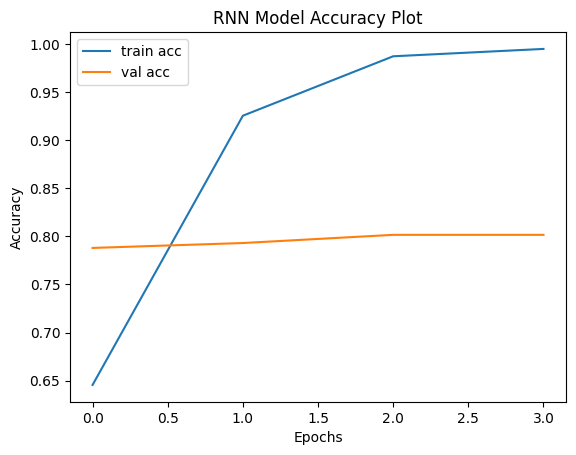

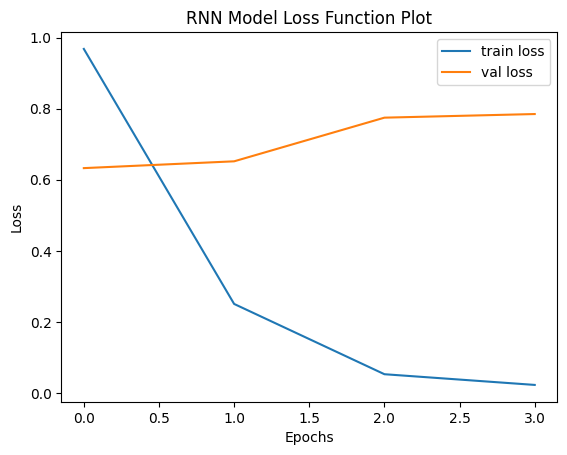

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


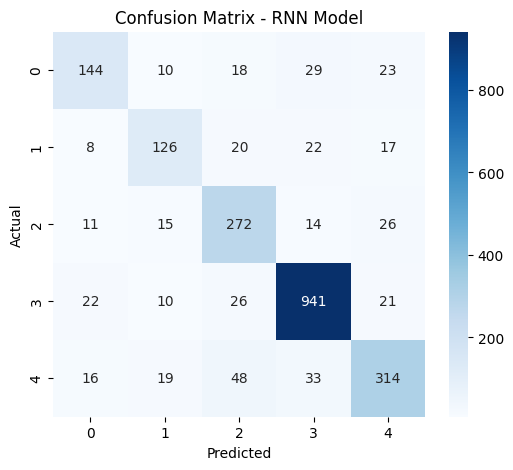

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.64      0.68       224
           1       0.70      0.65      0.68       193
           2       0.71      0.80      0.75       338
           3       0.91      0.92      0.91      1020
           4       0.78      0.73      0.76       430

    accuracy                           0.81      2205
   macro avg       0.76      0.75      0.76      2205
weighted avg       0.81      0.81      0.81      2205




--------------------------------------------------------------------
------------------------------ LSTM Model ------------------------------ 




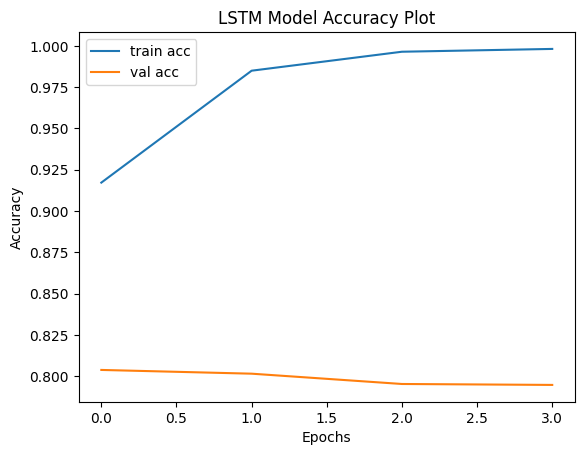

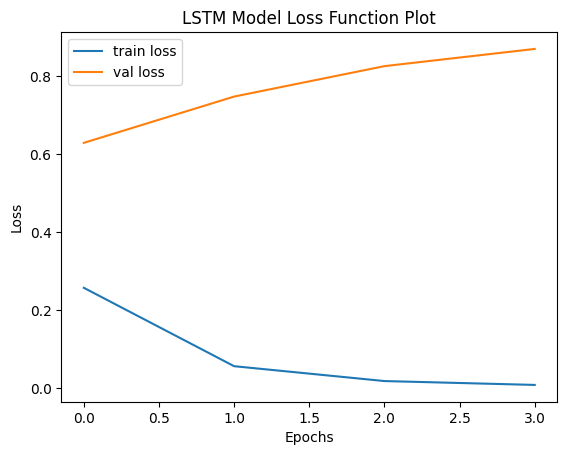

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


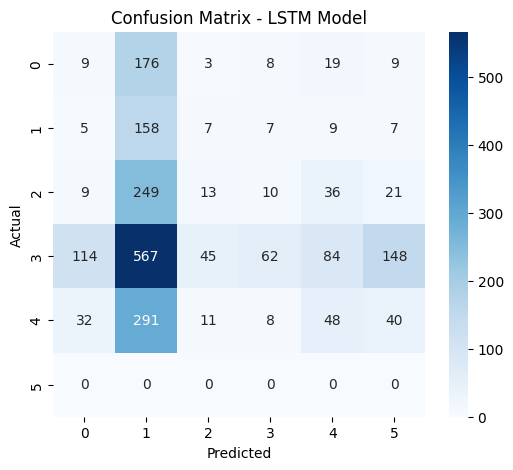

Classification Report:
               precision    recall  f1-score   support

           0       0.05      0.04      0.05       224
           1       0.11      0.82      0.19       193
           2       0.16      0.04      0.06       338
           3       0.65      0.06      0.11      1020
           4       0.24      0.11      0.15       430
           5       0.00      0.00      0.00         0

    accuracy                           0.13      2205
   macro avg       0.20      0.18      0.09      2205
weighted avg       0.39      0.13      0.11      2205




--------------------------------------------------------------------
------------------------------ Word2Vec LSTM Model3 ------------------------------ 




c:\Users\apsan\Desktop\Herald\ML\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\apsan\Desktop\Herald\ML\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\apsan\Desktop\Herald\ML\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


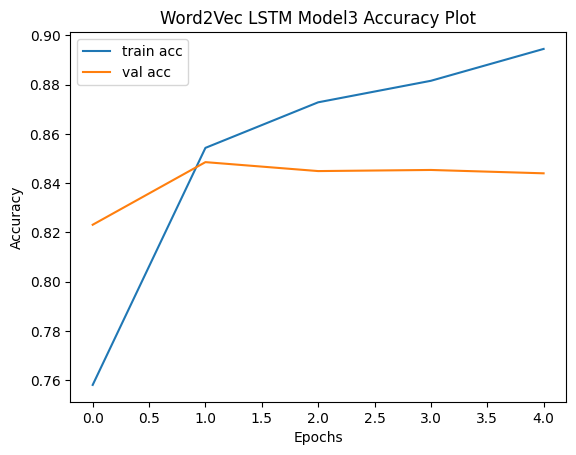

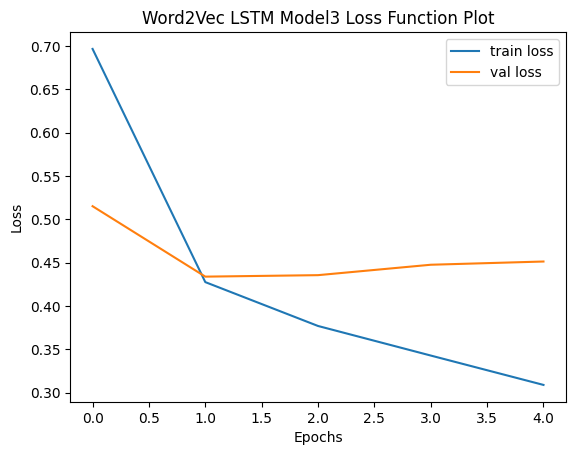

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


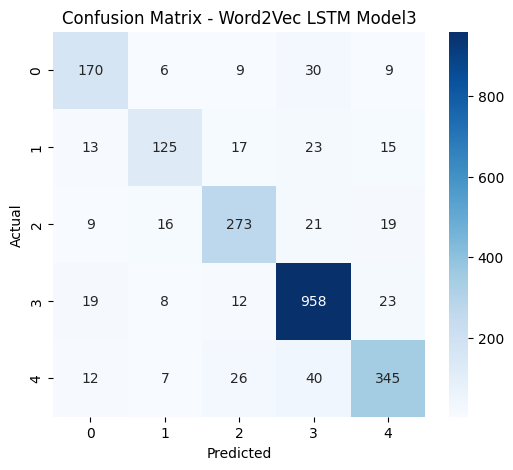

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.76      0.76       224
           1       0.77      0.65      0.70       193
           2       0.81      0.81      0.81       338
           3       0.89      0.94      0.92      1020
           4       0.84      0.80      0.82       430

    accuracy                           0.85      2205
   macro avg       0.82      0.79      0.80      2205
weighted avg       0.85      0.85      0.85      2205




--------------------------------------------------------------------


In [ ]:
for model_info in models:
    plot_history(model_info['history'], model_info['title'])
    evaluation_plot(model_info['model'], X_test_pad, y_test, model_info['title'])

In [ ]:
word2vec_model.save("news_category_model.h5")